# Step Detection using Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def load_file_names(folder_path):
    import os, glob
    files = list()
    for filename in glob.glob(os.path.join(folder_path, '*.txt')):
        files.append(filename)         
    return files

def open_file(filename_with_path):
    import os
    import pandas as pd
    isfile = os.path.exists(filename_with_path)
    if not isfile:
        print("  {} does not exist. Exiting...".format(filename_with_path))
    else :
        with open(filename_with_path,"r") as f:
            next(f)
            content = f.readlines()
        content = [x.split("\t") for x in content]
        df = pd.DataFrame(content)     
        df.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az', 'ClassLabel', 'StepLabel','None']
        
        # remove first row
        df =df.reindex(df.index.drop(0))
        
        # remove last column 'None'
        df = (df.iloc[:,:-1]).astype('float64')
        
        # removing -1 in stepLabel
        fdf = df.loc[(df['StepLabel']) >-1]
        
        return fdf.reset_index(drop=True)

In [3]:
raw_signal_all = open_file('T0_Id000000_ActLabelAndStepInfor.txt')

In [4]:
raw_signal_all.head()

,Gx,Gy,Gz,Ax,Ay,Az,ClassLabel,StepLabel
0,-0.088553,0.032715,-0.027293,0.092,-0.814,-0.182,0.0,1.0
1,-0.019311,0.011410,-0.016640,0.092,-0.866,-0.216,0.0,1.0
2,0.044605,0.043368,-0.005988,0.108,-0.900,-0.210,0.0,1.0
3,0.065911,0.027389,-0.000661,0.146,-0.906,-0.220,0.0,1.0
4,0.055258,0.027389,0.025970,0.188,-0.902,-0.216,0.0,1.0


In [5]:
raw_signal = raw_signal_all.iloc[:,0:6]

In [6]:
raw_signal.head()

,Gx,Gy,Gz,Ax,Ay,Az
0,-0.088553,0.032715,-0.027293,0.092,-0.814,-0.182
1,-0.019311,0.011410,-0.016640,0.092,-0.866,-0.216
2,0.044605,0.043368,-0.005988,0.108,-0.900,-0.210
3,0.065911,0.027389,-0.000661,0.146,-0.906,-0.220
4,0.055258,0.027389,0.025970,0.188,-0.902,-0.216


#### plotting Accelerometer data

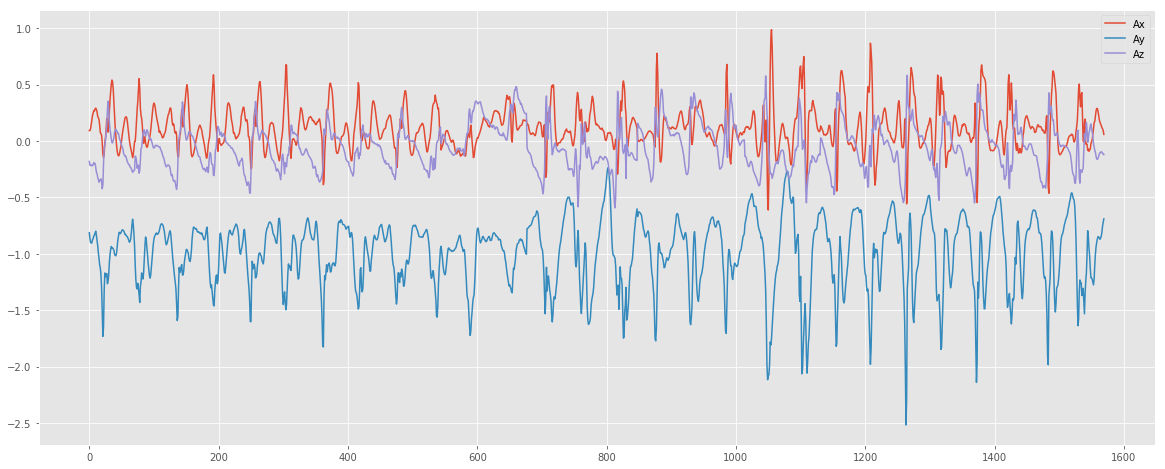

In [7]:
raw_signal[['Ax','Ay','Az']].plot(figsize=(20, 8))

#### plotting gyro data

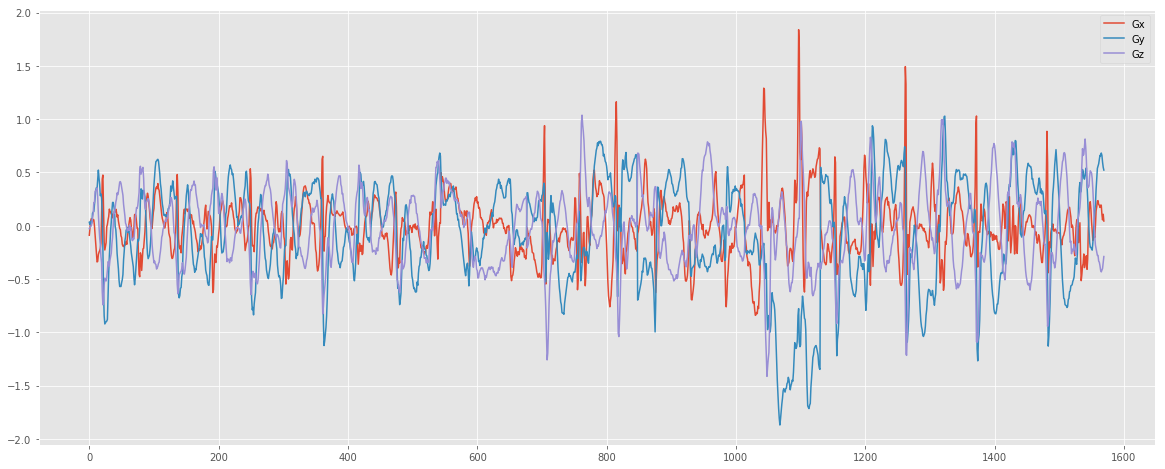

In [8]:
raw_signal[['Gx','Gy','Gz']].plot(figsize=(20, 8))

# 1. Filtering

https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform

In [9]:
def butter_lowpass(cutoff, nyq_freq, order):
    from scipy import signal
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(signal_, cutoff_freq, nyq_freq, order):
    '''
    data : 1D array
    '''
    from scipy import signal
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, signal_)
    return y
    

def filter_signal(raw_Signal, cutoff_frequency, nyq_freq, order):
    
    '''
    raw_Signal = DataFrame, shape(#of sample points,6)
    returns : filtered_signal, shape((#of sample points,6))
    '''
    
    filtered_Ax = butter_lowpass_filter(raw_Signal['Ax'], cutoff_frequency, nyq_freq, order)
    filtered_Ax = (pd.DataFrame(filtered_Ax, columns = ['Ax'], dtype = np.float64)).reset_index(drop = True)

    
    filtered_Ay = butter_lowpass_filter(raw_Signal['Ay'], cutoff_frequency, nyq_freq, order)
    filtered_Ay = (pd.DataFrame(filtered_Ay, columns = ['Ay'], dtype = np.float64)).reset_index(drop = True)

    filtered_Az = butter_lowpass_filter(raw_Signal['Az'], cutoff_frequency, nyq_freq, order)
    filtered_Az = (pd.DataFrame(filtered_Az, columns = ['Az'], dtype = np.float64)).reset_index(drop = True)

    filtered_Gx = butter_lowpass_filter(raw_Signal['Gx'], cutoff_frequency, nyq_freq, order)
    filtered_Gx = (pd.DataFrame(filtered_Gx, columns = ['Gx'], dtype = np.float64)).reset_index(drop = True)

    filtered_Gy = butter_lowpass_filter(raw_Signal['Gy'], cutoff_frequency, nyq_freq, order)
    filtered_Gy = (pd.DataFrame(filtered_Gy, columns = ['Gy'], dtype = np.float64)).reset_index(drop = True)
    
    filtered_Gz = butter_lowpass_filter(raw_Signal['Gz'], cutoff_frequency, nyq_freq, order)
    filtered_Gz = (pd.DataFrame(filtered_Gz, columns = ['Gz'], dtype = np.float64)).reset_index(drop = True)

    filtered_signal = pd.concat([filtered_Gx,filtered_Gy,filtered_Gz,filtered_Ax,filtered_Ay,filtered_Az],axis = 1) 
 
    
    return filtered_signal

In [10]:
cutoff_frequency = 15.0 # in Hz
signal_Ay = raw_signal['Ay']
sample_rate = 100 # in Hz
filtered_Ay = butter_lowpass_filter(signal_Ay, cutoff_frequency, sample_rate/2, order = 4)
diff = np.array(signal_Ay)-np.array(filtered_Ay)
filtered_Ay

c:\program files\python36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([-0.81398653, -0.85888339, -0.8918337 , ..., -0.765367  ,
       -0.72725595, -0.69085087])

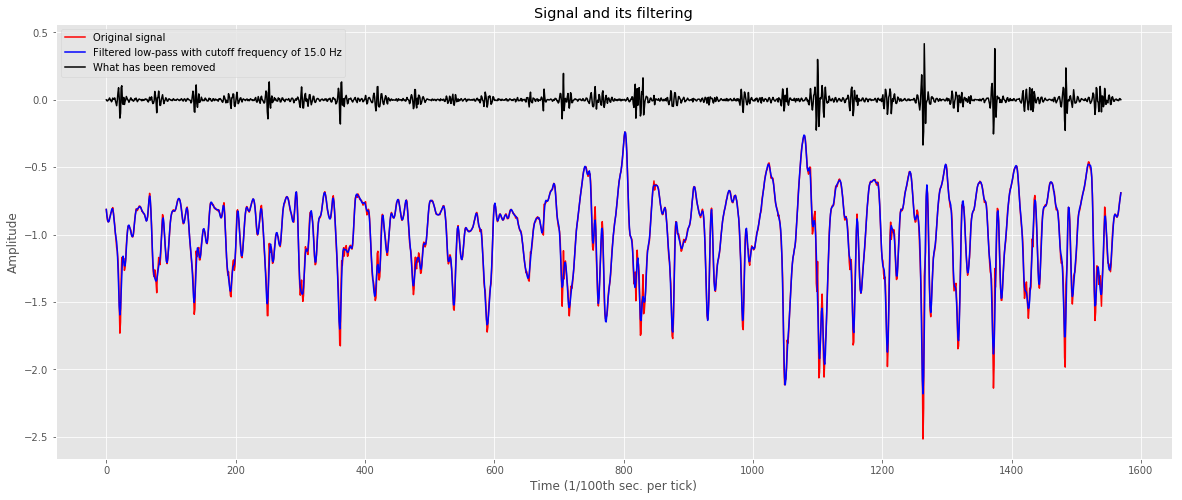

In [12]:
# Visualize filtering
plt.figure(figsize=(20, 8))
plt.plot(signal_Ay, color='red', label="Original signal")
plt.plot(filtered_Ay, color='blue', label="Filtered low-pass with cutoff frequency of {} Hz".format(cutoff_frequency))
plt.plot(diff, color='black', label="What has been removed")
plt.title("Signal and its filtering")
plt.xlabel('Time (1/100th sec. per tick)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [13]:
filtered_Ay.shape

(1570,)

# 2. Segmentation

In [14]:
# https://stackoverflow.com/questions/45730504/how-do-i-create-a-sliding-window-with-a-50-overlap-with-a-numpy-array

def signal_segmentation(signal, window_size, overlap = 0.5):
    '''
    signal : 1D numpy array or pandas Dataframe
    overlap : in percentage
    
    returns :numpy array
    '''
    
    if (window_size < 1):
        raise ValueError("Sliding window size may not be zero or negative")
        
    if (window_size > len(signal)):
        raise ValueError("Sliding window size may not exceed size of signal.")
    
    if not(0<overlap<= 1):
        raise ValueError("Window overlap must be in within interval 0 and 1.")    
        
    sh = (signal.size - window_size + 1, window_size)
    st = signal.strides * 2    
    segmented_signal = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::int((overlap*window_size)+1)]
   
    return segmented_signal.transpose()

def segment_signal(raw_signal, window_size, overlap):
    
    '''
    raw_signal = DataFrame, shape(#of sample points,6)
    returns : filtered_signal, shape((#of sample points,6))
    '''
  
    segmented_Ax = signal_segmentation(raw_signal['Ax'], window_size, overlap)
    cols = ['Ax_segment_'+str(i+1) for i in range(len(segmented_Ax.transpose()))]
    segmented_Ax = (pd.DataFrame(segmented_Ax, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Ay = signal_segmentation(raw_signal['Ay'], window_size, overlap)
    cols = ['Ay_segment_'+str(i+1) for i in range(len(segmented_Ay.transpose()))]
    segmented_Ay = (pd.DataFrame(segmented_Ay, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Az = signal_segmentation(raw_signal['Az'],window_size, overlap)
    cols = ['Az_segment_'+str(i+1) for i in range(len(segmented_Az.transpose()))]
    segmented_Az = (pd.DataFrame(segmented_Az, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Gx = signal_segmentation(raw_signal['Gx'],window_size, overlap)
    cols = ['Gx_segment_'+str(i+1) for i in range(len(segmented_Gx.transpose()))]
    segmented_Gx = (pd.DataFrame(segmented_Gx, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_Gy = signal_segmentation(raw_signal['Gy'], window_size, overlap)
    cols = ['Gy_segment_'+str(i+1) for i in range(len(segmented_Gy.transpose()))]
    segmented_Gy = (pd.DataFrame(segmented_Gy, columns = cols, dtype = np.float64)).reset_index(drop = True)
    
    segmented_Gz = signal_segmentation(raw_signal['Gz'], window_size, overlap)
    cols = ['Gz_segment_'+str(i+1) for i in range(len(segmented_Gz.transpose()))]
    segmented_Gz = (pd.DataFrame(segmented_Gz, columns = cols, dtype = np.float64)).reset_index(drop = True)

    segmented_signal = pd.concat([segmented_Gx,segmented_Gy,segmented_Gz,segmented_Ax,segmented_Ay,segmented_Az],axis = 1) 
     
    return segmented_signal

In [16]:
segmented_Ay = signal_segmentation(signal_Ay, window_size = 128, overlap = .5)
segmented_Ay

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Series.strides is deprecated and will be removed in a future version


array([[-0.814, -0.816, -1.094, ..., -0.518, -1.134, -1.388],
       [-0.866, -0.742, -1.162, ..., -0.602, -1.206, -1.174],
       [-0.9  , -0.694, -1.212, ..., -0.656, -1.276, -1.032],
       ...,
       [-0.796, -1.338, -1.092, ..., -1.546, -0.892, -1.096],
       [-0.824, -1.39 , -1.122, ..., -1.622, -1.056, -1.   ],
       [-0.89 , -1.454, -1.214, ..., -1.544, -1.268, -0.936]])

In [17]:
segmented_Ay.shape

(128, 23)

#### original signal vs segmented signal

In [19]:
# segmentation visualize
final = list()
for i in range(len(segmented_Ay)):
    for j in range(len(segmented_Ay[i])):
        final.append(segmented_Ay[i][j])
final = pd.DataFrame(final)
final.shape

(2944, 1)

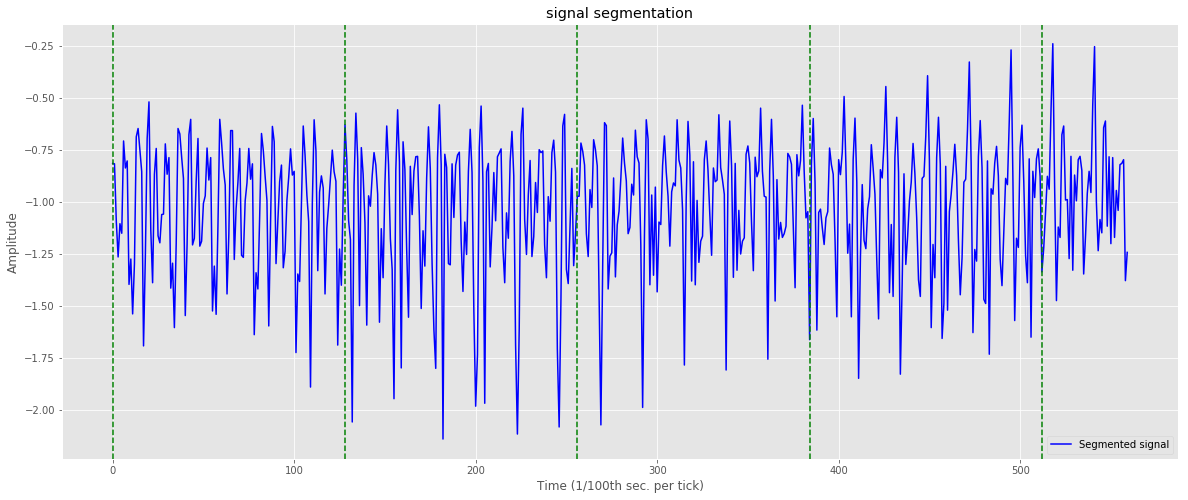

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(final[0:560], color='blue', label="Segmented signal")
plt.title("signal segmentation")
plt.xlabel('Time (1/100th sec. per tick)')
plt.ylabel('Amplitude')
xposition = [0,128, 256,128*3,128*4] 
for xc in xposition:
    plt.axvline(x=xc, color='green', linestyle='--')
plt.legend()
plt.show()

# 3. Feature Extraction   

In [26]:
def feature_vector(segmented_signal):
    
    '''
    segmented_signal : pandas DataFrame, shape(#of samples in a segment,#of segment*6)
    returns: feature_vector, DataFrame, shape(#of segments, #of features calculated)
    
    '''
    import pandas as pd
       
    r,c = segmented_signal.shape    
    feature_matrix = pd.DataFrame()
    for i in range(int(c/6)):
        Ax = pd.DataFrame(segmented_signal['Ax_segment_'+str(i+1)])
        Ay = pd.DataFrame(segmented_signal['Ay_segment_'+str(i+1)])
        Az = pd.DataFrame(segmented_signal['Az_segment_'+str(i+1)])
        Gx = pd.DataFrame(segmented_signal['Gx_segment_'+str(i+1)])
        Gy = pd.DataFrame(segmented_signal['Gy_segment_'+str(i+1)])
        Gz = pd.DataFrame(segmented_signal['Gz_segment_'+str(i+1)])
        segment = pd.concat([Gx,Gy,Gz,Ax,Ay,Az],axis = 1)
        feature = time_domain_features(segment)
        # time domain+frequency+wavelet domain ko feature vector lai ni add garna parxa
        # feature_t = time_domain_features(segment)
        # feature_f = frequency_domain_features(segment)
        # feature_w = wavelet_domain_features(segment)
        # feature = (pd.concat([feature_t,feature_f,feature_w],axis = 1)).reset_index(drop = True) 
        
        feature_matrix = (pd.concat([feature_matrix,feature],axis = 0)).reset_index(drop = True) 
        
    return feature_matrix  

## (a).Time Domain Feature Extraction

In [27]:
TIME_DOMAIN_FEATURES =['tAbsX',                       
                       'tSMA_x',
                       'tSMA_y',
                       'tSMA_z',                       
                       'tEnergy_x',
                       'tEnergy_y',
                       'tEnergy_z',                       
                       'tIQR_x',
                       'tIQR_y',
                       'tIQR_z',                       
                       'tEntropy_x',
                       'tEntropy_y',
                       'tEntropy_z',                       
                       'tCorrelation_xy',
                       'tCorrelation_yz',
                       'tCorrelation_xz',                       
                       't_Percentile_5th_x',
                       't_Percentile_10th_x',
                       't_Percentile_15th_x',
                       't_Percentile_20th_x',                       
                       't_Percentile_30th_x',
                       't_Percentile_35th_x',
                       't_Percentile_40th_x',
                       't_Percentile_45th_x',                       
                       't_Percentile_55th_x',
                       't_Percentile_60th_x',
                       't_Percentile_65th_x',
                       't_Percentile_70th_x',                       
                       't_Percentile_80th_x',
                       't_Percentile_85th_x',
                       't_Percentile_90th_x',
                       't_Percentile_95th_x',
                       't_Percentile_100th_x',                       
                       't_Percentile_5th_y',
                       't_Percentile_10th_y',
                       't_Percentile_15th_y',
                       't_Percentile_20th_y',                    
                       't_Percentile_30th_y',
                       't_Percentile_35th_y',
                       't_Percentile_40th_y',
                       't_Percentile_45th_y',                      
                       't_Percentile_55th_y',
                       't_Percentile_60th_y',
                       't_Percentile_65th_y',
                       't_Percentile_70th_y',                       
                       't_Percentile_80th_y',
                       't_Percentile_85th_y',
                       't_Percentile_90th_y',
                       't_Percentile_95th_y',
                       't_Percentile_100th_y',                       
                       't_Percentile_5th_z',
                       't_Percentile_10th_z',
                       't_Percentile_15th_z',
                       't_Percentile_20th_z',                       
                       't_Percentile_30th_z',
                       't_Percentile_35th_z',
                       't_Percentile_40th_z',
                       't_Percentile_45th_z',                      
                       't_Percentile_55th_z',
                       't_Percentile_60th_z',
                       't_Percentile_65th_z',
                       't_Percentile_70th_z',                       
                       't_Percentile_80th_z',
                       't_Percentile_85th_z',
                       't_Percentile_90th_z',
                       't_Percentile_95th_z',
                       't_Percentile_100th_z',
                       
                      ]
def time_domain_features(segmented_signal):
    '''segmented_signal: numpy array, shape(#of samples in window ,6) e.g 128*6
        returns = shape(1, #of features calculated)
        
    '''
    import numpy as np
    import pandas as pd
    
    segmented_signal = pd.DataFrame(segmented_signal,dtype = np.float64)     
    segmented_signal.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az']
    
    # mean 
    mean = (pd.DataFrame(segmented_signal.mean(axis = 0))).transpose()
    mean.columns =['t_mean_Ax','t_mean_Ay','t_mean_Az','t_mean_Gx','t_mean_Gy','t_mean_Gz']
    mean = mean.reset_index(drop = True)
    
    # standard deviation
    std = (pd.DataFrame(segmented_signal.std(axis = 0))).transpose()
    std.columns =['t_std_Ax','t_std_Ay','t_std_Az','t_std_Gx','t_std_Gy','t_std_Gz']
    std = std.reset_index(drop = True)
    
    # variance
    variance = (pd.DataFrame(segmented_signal.median(axis = 0))).transpose()
    variance.columns =['t_variance_Ax','t_variance_Ay','t_variance_Az','t_variance_Gx','t_variance_Gy','t_variance_Gz']
    variance = variance.reset_index(drop = True)
    
    # max
    max_ = (pd.DataFrame(segmented_signal.max(axis = 0))).transpose()
    max_.columns =['t_max_Ax','t_max_Ay','t_max_Az','t_max_Gx','t_max_Gy','t_max_Gz']
    max_ = max_.reset_index(drop = True)
    
    # min
    min_ = (pd.DataFrame(segmented_signal.min(axis = 0))).transpose()
    min_.columns =['t_min_Ax','t_min_Ay','t_min_Az','t_min_Gx','t_min_Gy','t_min_Gz']
    min_ = min_.reset_index(drop = True)
    
    # mean absolute deviation (MAD)
    MAD = (pd.DataFrame(segmented_signal.mad(axis = 0))).transpose()
    MAD.columns =['t_MAD_Ax','t_ MAD_Ay','t_ MAD_Az','t_ MAD_Gx','t_ MAD_Gy','t_ MAD_Gz']
    MAD = MAD.reset_index(drop = True)
    
    # skewness
    skewness = (pd.DataFrame(segmented_signal.skew(axis = 0))).transpose()
    skewness.columns =['t_skewness_Ax','t_skewness_Ay','t_skewness_Az','t_skewness_Gx','t_skewness_Gy','t_skewness_Gz']
    skewness = skewness.reset_index(drop = True)
    
    # kurtosis
    kurtosis = (pd.DataFrame(segmented_signal.kurtosis(axis = 0))).transpose()
    kurtosis.columns =['t_kurtosis_Ax','t_kurtosis_Ay','t_kurtosis_Az','t_kurtosis_Gx','t_kurtosis_Gy','t_kurtosis_Gz']
    kurtosis = kurtosis.reset_index(drop = True)
    
    # Q1
    Q1 = (segmented_signal.quantile([0.25]))
    Q1.columns =['t_Q1_Ax','t_Q1','t_Q1_Az','t_Q1_Gx','t_Q1_Gy','t_Q1_Gz']
    Q1 = Q1.reset_index(drop = True)
    
    
    # median (Q2)
    median = (pd.DataFrame(segmented_signal.median(axis = 0))).transpose()
    median.columns =['t_median_Ax','t_median_Ay','t_median_Az','t_median_Gx','t_median_Gy','t_median_Gz']
    median = median.reset_index(drop = True)
    
    # Q3
    Q3 = (segmented_signal.quantile([0.25]))
    Q3.columns =['t_Q3_Ax','t_Q3','t_Q3_Az','t_Q3_Gx','t_Q3_Gy','t_Q3_Gz']
    Q3 = Q3.reset_index(drop = True)
    
    # Signal Magnitude Area 
    
    #----------------------------------------------------------------------------------------------
    # https://dsp.stackexchange.com/questions/18649/signal-magnitude-area
    # https://en.wikipedia.org/wiki/Signal_magnitude_area
    def signal_magnitude_area(x, y, z):
        import numpy as np        
        sum_ = 0
        if not(len(x)==len(y)) or not(len(x)==len(z)):
            raise ValueError(" Length of x,y,z must be same.")
            
        for i in range (len(x)):
            sum_ += (np.abs(x[i]) + np.abs(y[i]) + np.abs(z[i]))
        return sum_ /len(x)
    
    Ax,Ay,Az =segmented_signal['Ax'].values,segmented_signal['Ay'].values,segmented_signal['Az'].values
    Gx,Gy,Gz =segmented_signal['Gx'].values,segmented_signal['Gy'].values,segmented_signal['Gz'].values
    sma_Acc = signal_magnitude_area(Ax, Ay,Az)
    sma_Gyro = signal_magnitude_area(Gx, Gy,Gz)
    sma = (pd.DataFrame(np.array([sma_Acc,sma_Gyro]),dtype = np.float64)).transpose()
    sma.columns = ['t_sma_Acc','t_sma_Gyro']
    sma = sma.reset_index(drop = True)
    
       
    # simple moving averages(SMA)
    
    #----------------------------------------------------------------------------------------------
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4719690/   
    
    feature_vector = pd.concat([mean,std,variance,max_,min_,MAD,skewness,kurtosis,Q1,median,Q3,sma],axis = 1)  
    
    return feature_vector

## (b). Frequency Domain Feature Extraction

## (c). Wavelet Domain Feature Extraction

# 4. Data set Preparation

In [28]:
def create_X(files,cutoff_frequency,nyq_freq, order,window_size,overlap):
    import pandas as pd
    from tqdm import tqdm
    No_of_files = len(files)
    X = pd.DataFrame()
    for i in tqdm(range(No_of_files)):
        #print('Opening {}th files...'.format(i+1))
        raw_signal_all =open_file(files[i])
        
        #print(files[i])
        raw_signal = raw_signal_all.iloc[:,0:6]        
        
        #print('Filtering {}th files...'.format(i+1))
        filtered_signal = filter_signal(raw_signal, cutoff_frequency, nyq_freq, order)        
        
        #print('Segmenting {}th files...'.format(i+1))
        segmented_signal = segment_signal(filtered_signal, window_size, overlap)
        
        #print('Extracting features from {}th files...'.format(i+1))
        x_ = feature_vector(segmented_signal)
        X = (pd.concat([x_,X],axis = 0)).reset_index(drop = True)
        #print("*****************************************************")

    return X

In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm

files_center = load_file_names('E:\Study\Master\Rostock University\Thesis\DataSet\Center')
files_left = load_file_names('E:\Study\Master\Rostock University\Thesis\DataSet\Left')
files_right = load_file_names('E:\Study\Master\Rostock University\Thesis\DataSet\Right')

cutoff_frequency = 15.0
sample_rate = 100
nyq_freq = sample_rate/2
order = 4
window_size = 128
overlap = 0.5

x_center = create_X(files_center,cutoff_frequency,nyq_freq, order,window_size,overlap)
x_right =create_X(files_right,cutoff_frequency,nyq_freq, order,window_size,overlap)
x_left = create_X(files_left,cutoff_frequency,nyq_freq, order,window_size,overlap)
X = (pd.concat([x_center,x_left,x_right],axis = 0)).reset_index(drop = True)

100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [05:07<00:00,  1.54it/s]


In [31]:
X.head()

,t_mean_Ax,t_mean_Ay,t_mean_Az,t_mean_Gx,t_mean_Gy,t_mean_Gz,t_std_Ax,t_std_Ay,t_std_Az,t_std_Gx,...,t_median_Gy,t_median_Gz,t_Q3_Ax,t_Q3,t_Q3_Az,t_Q3_Gx,t_Q3_Gy,t_Q3_Gz,t_sma_Acc,t_sma_Gyro
0,-0.033109,0.013355,0.011473,0.058087,-1.013779,0.212857,0.197738,0.283273,0.213999,0.121923,...,-0.965207,0.188694,-0.132744,-0.210161,-0.144246,-0.009377,-1.085369,0.115634,1.332140,0.555752
1,-0.006382,0.035796,-0.003232,0.064967,-1.006069,0.198852,0.216725,0.268532,0.217144,0.119095,...,-0.954434,0.185652,-0.132167,-0.164542,-0.160535,0.008953,-1.094924,0.115634,1.314512,0.568354
2,-0.012519,-0.019030,-0.011149,0.049225,-1.007419,0.189122,0.196025,0.272532,0.201256,0.119983,...,-0.947813,0.180268,-0.148119,-0.240433,-0.113880,-0.023820,-1.087163,0.096110,1.299419,0.550438
3,-0.017754,0.010278,-0.027809,0.065828,-1.034552,0.208715,0.212046,0.276557,0.229470,0.096446,...,-0.992102,0.182509,-0.156607,-0.208679,-0.177982,0.000226,-1.138033,0.119159,1.337183,0.589588
4,-0.011012,0.017829,0.030925,0.065014,-1.043840,0.217396,0.171802,0.234754,0.221748,0.113013,...,-0.994213,0.183909,-0.112026,-0.108404,-0.110136,-0.005495,-1.192999,0.130106,1.366123,0.503557
